# Crime Project Part 2

Brittany Lassiter

## Objective

>For this phase of the project, you will be helping Chicago law enforcement allocate resources for the next 6 months.

> We will be forecasting and comparing data for Narcotics and Assault.

## Imports and Custom functions

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
import pmdarima as pm

In [14]:
# importing glob for files
import os,glob
os.makedirs('Data/',exist_ok=True)

In [15]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [17]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [18]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

## Loading Data

In [19]:
# get list of files from folder
crime_files = sorted(glob.glob('Data/Chicago'+"*.csv"))
df = pd.concat([pd.read_csv(f) for f in crime_files])
df

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1311933,01/01/2001 01:00:00 AM,SEX OFFENSE,CRIMINAL SEXUAL ABUSE,RESIDENCE,True,False,1434,14.0,NaN,41.910797,-87.682214
1,1317380,01/01/2001 01:00:00 PM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,911,9.0,NaN,41.807498,-87.689155
2,1422085,01/01/2001 01:00:00 AM,OTHER OFFENSE,TELEPHONE THREAT,RESIDENCE,False,True,1023,10.0,NaN,41.858050,-87.695513
3,1323184,01/01/2001 01:00:00 PM,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,2213,22.0,NaN,41.707671,-87.666996
4,1313086,01/01/2001 01:00:00 PM,THEFT,OVER $500,OTHER,False,False,1732,17.0,NaN,41.953070,-87.716716
...,...,...,...,...,...,...,...,...,...,...,...,...
239040,12937822,12/31/2022 12:50:00 PM,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
239041,12938029,12/31/2022 12:50:00 PM,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
239042,12938420,12/31/2022 12:52:00 PM,ASSAULT,SIMPLE,COMMERCIAL / BUSINESS OFFICE,False,False,1432,14.0,32.0,41.930693,-87.685657
239043,12937583,12/31/2022 12:52:00 AM,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098


## Setting Datetime and Transforming the data

In [26]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p')

In [27]:
df['Date']

0        2001-01-01 01:00:00
1        2001-01-01 13:00:00
2        2001-01-01 01:00:00
3        2001-01-01 13:00:00
4        2001-01-01 13:00:00
                 ...        
239040   2022-12-31 12:50:00
239041   2022-12-31 12:50:00
239042   2022-12-31 12:52:00
239043   2022-12-31 00:52:00
239044   2022-12-31 12:59:00
Name: Date, Length: 7713684, dtype: datetime64[ns]

In [31]:
main_crimes = ['NARCOTICS', 'ASSAULT']
subset = df[df['Primary Type'].isin(main_crimes)]
main_crimes

['NARCOTICS', 'ASSAULT']

In [30]:
crime_size = subset.groupby('Primary Type').resample('MS').size()

<Axes: xlabel='Date'>

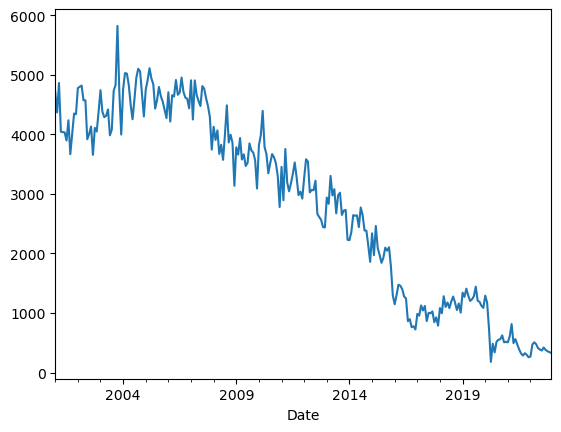

In [33]:
crime_size.loc['NARCOTICS'].plot()

<Axes: xlabel='Date'>

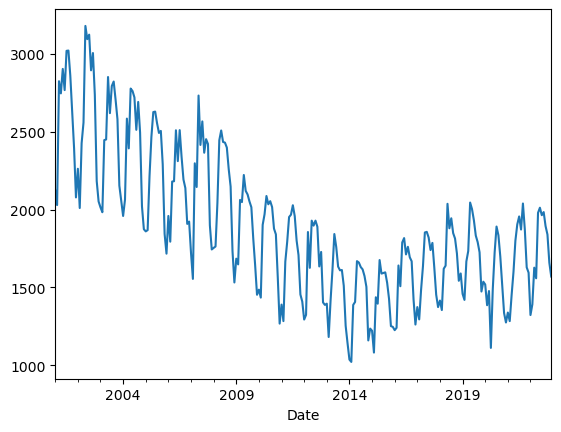

In [34]:
crime_size.loc['ASSAULT'].plot()

### Assults Data

In [35]:
# Transform the data to obtain a time series of the crime count per month using .size().
assault_df = df[df['Primary Type'] == 'ASSAULT']
assault_ts = assault_df.resample('MS').size()

# Check for and address null values
assault_ts.isnull().sum()

0

**Decomposing**

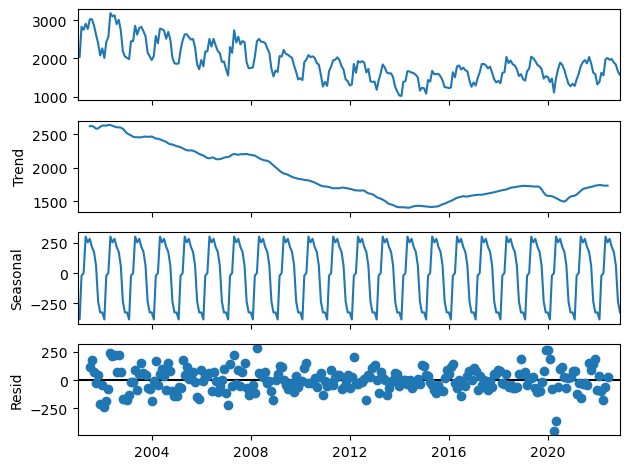

In [36]:
# Decompose the Time series to detect seasonality and decide whether to use a seasonal model or not
decomp_assault = tsa.seasonal_decompose(assault_ts)
decomp_assault.plot();

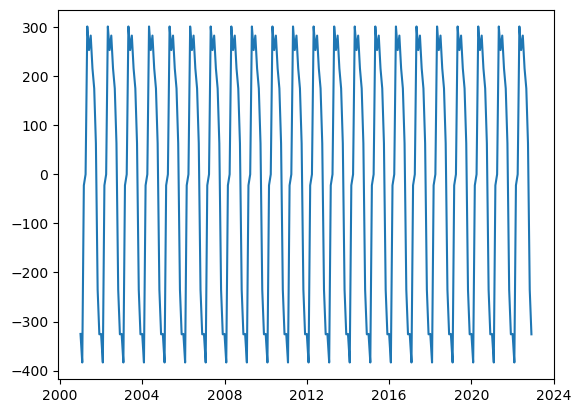

In [37]:
plt.plot(decomp_assault.seasonal.loc['2001':])

**Seasonal or NonSeasonal**

In [39]:
d = ndiffs(assault_ts)
D = nsdiffs(assault_ts, m=12)

d, D

(1, 0)

In [40]:
assault_ts_diff = assault_ts.diff().dropna()

**ACF and PACF**

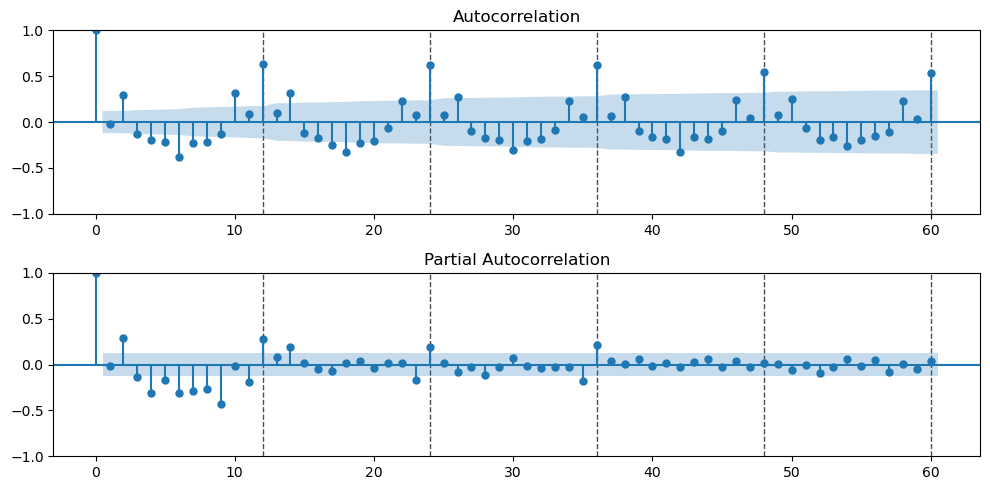

In [41]:
# Use the ACF and PACF plots of stationarized data to estimate initial orders
plot_acf_pacf(
    assault_ts_diff, m=12, pacf_kws={'method': 'ywm'}, annotate_seas=True, nlags=60
);

**Splitting the Assult Data**

In [44]:
# Split the time series into training and test data (Remember we want to predict 6 months)
train, test = train_test_split(assault_ts, test_size=6)

In [45]:
# Fit a manual ARIMA/SARIMA model based on the orders determined during your exploration.
p = 1
d = 1 # identified above
q = 1

P = 1
D = 0 # identified baove
Q = 1

m = 12

sarima = tsa.ARIMA(train, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()

In [46]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  258
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1613.102
Date:                          Thu, 30 Nov 2023   AIC                           3236.204
Time:                                  21:14:18   BIC                           3253.950
Sample:                              01-01-2001   HQIC                          3243.340
                                   - 06-01-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9738      0.040     24.346      0.000       0.895       1.052
ma.L1         -0.9995      0.011    -89.715      0.000      -1.021      -0.978
ar.S.L12       0.9965      0.002    419.942      0.000       0.992       1.001
ma.S.L12      -0.8349      0.053    -15.811      0.000      -0.938      -0.731
sigma2      1.437e+04   1183.287     12.146      0.000    1.21e+04    1.67e+04
===================================================================================
Ljung-Box (L1) (Q):                  22.44   Jarque-Bera (JB):                 8.46
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               0.56   Skew:                             0.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
# Make forecasts with your model.
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()

In [48]:
forecast_df['mean']

2022-07-01    2031.870163
2022-08-01    1968.830120
2022-09-01    1941.547928
2022-10-01    1827.030412
2022-11-01    1587.940055
2022-12-01    1540.545949
Freq: MS, Name: mean, dtype: float64

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Date'>)

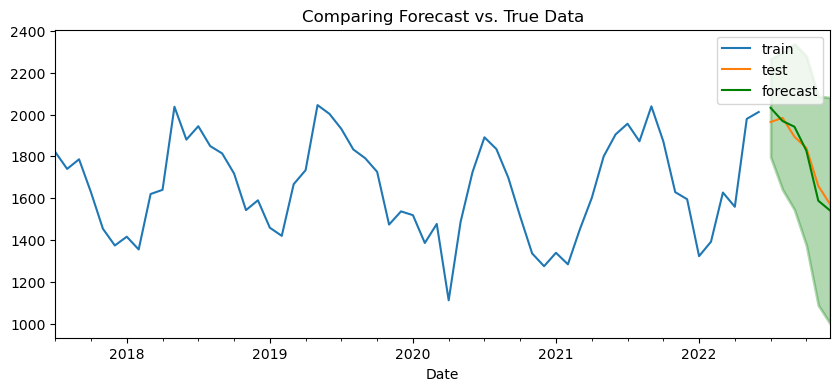

In [50]:
# Plot the forecasts versus the test data
plot_forecast(train, test, forecast_df, n_train_lags=60)

In [54]:
# Obtain metrics for evaluation
regression_metrics_ts(test, forecast_df['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 40.679
- MSE = 2,197.093
- RMSE = 46.873
- R^2 = 0.907
- MAPE = 2.27%


In [55]:
# Tune with pmdarima's auto_arima
auto_model = pm.auto_arima(train, seasonal=True)

In [56]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  258
Model:               SARIMAX(4, 1, 3)   Log Likelihood               -1638.245
Date:                Thu, 30 Nov 2023   AIC                           3292.489
Time:                        21:16:29   BIC                           3320.882
Sample:                    01-01-2001   HQIC                          3303.907
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3079      0.078      3.952      0.000       0.155       0.461
ar.L2          1.0386      0.057     18.334      0.000       0.928       1.150
ar.L3         -0.6806      0.057    -11.950      0.000      -0.792      -0.569
ar.L4         -0.4135      0.075     -5.520      0.000      -0.560      -0.267
ma.L1         -0.8027      0.039    -20.757      0.000      -0.878      -0.727
ma.L2         -0.8117      0.039    -20.896      0.000      -0.888      -0.736
ma.L3          0.9430      0.031     30.034      0.000       0.882       1.005
sigma2      2.201e+04   2071.480     10.625      0.000    1.79e+04    2.61e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):                10.38
Prob(Q):                              0.47   Prob(JB):                         0.01
Heteroskedasticity (H):               0.40   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
auto_model.order, auto_model.seasonal_order

((4, 1, 3), (0, 0, 0, 0))

In [58]:
# Fit a model on training data with the best parameters from auto_arima
training_model = tsa.ARIMA(train, order = auto_model.order).fit()

C:\Users\blass\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\blass\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [60]:
forecast_df2 = training_model.get_forecast(steps=len(test)).summary_frame()

In [61]:
# Obtain metrics for evaluation
regression_metrics_ts(test, forecast_df2['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 73.396
- MSE = 7,353.811
- RMSE = 85.754
- R^2 = 0.689
- MAPE = 4.00%


(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Date'>)

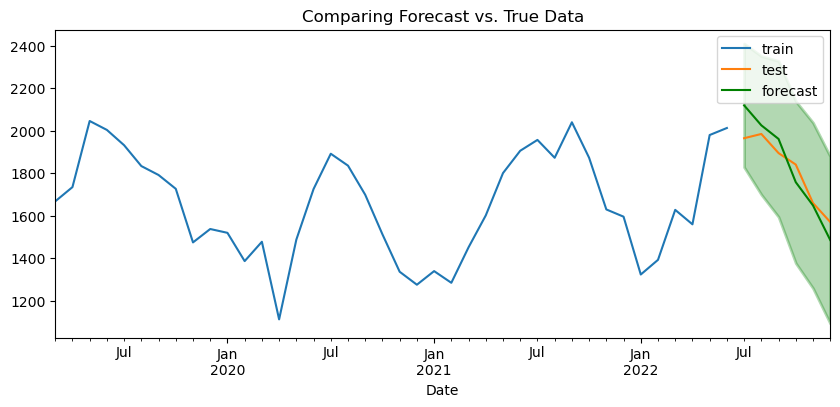

In [62]:
# Make forecasts with the auto_arima model
# Plot the forecasts versus the test data
plot_forecast(train, test, forecast_df2, n_train_lags=40)

In [64]:
# using the the second forcast data 
p = 4
d = 1 # 2nd forcasted above
q = 3

P = 0
D = 0 # 2nd forcasted above
Q = 0

m = 0

sarima = tsa.ARIMA(assault_ts, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()

C:\Users\blass\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\blass\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [65]:
final_forecast = sarima.get_forecast(steps=6).summary_frame()

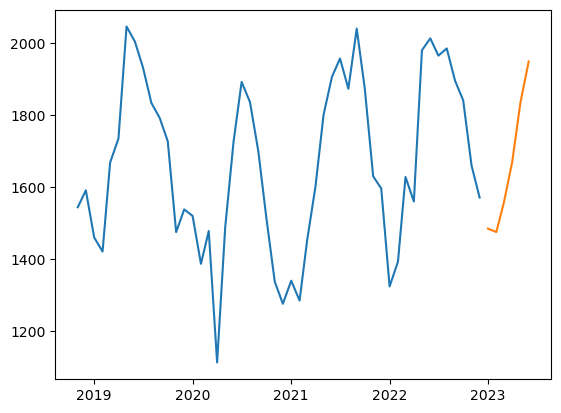

In [67]:
plt.plot(assault_ts.tail(50))
plt.plot(final_forecast['mean'])

In [68]:
assault_ts.tail()

Date
2022-08-01    1984
2022-09-01    1894
2022-10-01    1840
2022-11-01    1659
2022-12-01    1570
Freq: MS, dtype: int64

In [69]:
final_forecast

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-01-01,1483.573367,146.637357,1196.169429,1770.977305
2023-02-01,1474.214343,164.294547,1152.202947,1796.225739
2023-03-01,1556.312399,188.399960,1187.055262,1925.569535
2023-04-01,1669.153257,197.630883,1281.803844,2056.502671
2023-05-01,1832.139883,205.286226,1429.786273,2234.493493
2023-06-01,1947.904355,208.971699,1538.327351,2357.481358


In [80]:
final_forecast['mean'][-1] - final_forecast['mean'][0]
print(f"The predicted net change is {final_forecast['mean'][-1] - final_forecast['mean'][0]}. ")

The predicted net change is 464.3309882125368. 


In [79]:
(464.3309882125368 / final_forecast['mean'][-1]) * 100
print(f"The raw delta percentage is {(464.3309882125368 / final_forecast['mean'][-1]) * 100}.")

The raw delta percentage is 23.837463428444853.


### Narcotics

In [82]:
# Transform the data to obtain a time series of the crime count per month using .size().
df_narcotics = df[df['Primary Type'] == 'NARCOTICS']
df_narcotics = df_narcotics.resample('MS').size()

# Check for and address null values
df_narcotics.isnull().sum()

0

**Decomposing**

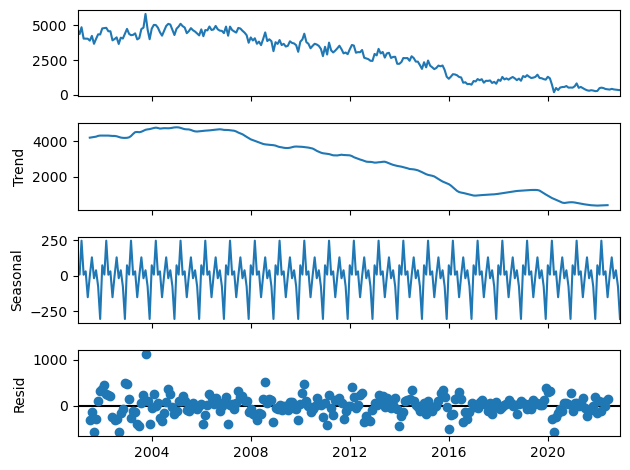

In [84]:
# Decompose the Time series to detect seasonality and decide whether to use a seasonal model or not
decomp_narcotics = tsa.seasonal_decompose(df_narcotics)
decomp_narcotics.plot();

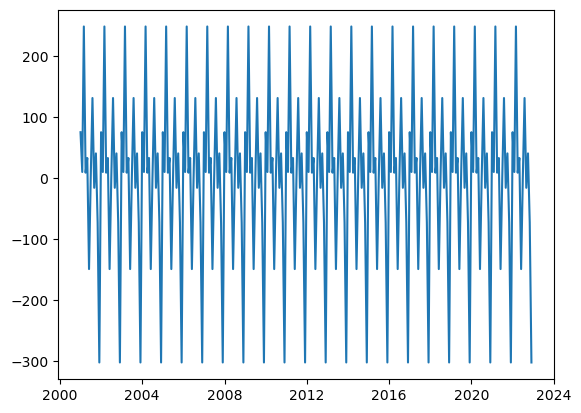

In [85]:
plt.plot(decomp_narcotics.seasonal.loc['2001':])

**Seasonal or NonSeasonal**

In [86]:
d = ndiffs(df_narcotics)
D = nsdiffs(df_narcotics, m=12)

d, D

(1, 0)

In [87]:
df_narcotics_diff = df_narcotics.diff().dropna()

**ACF and PACF**

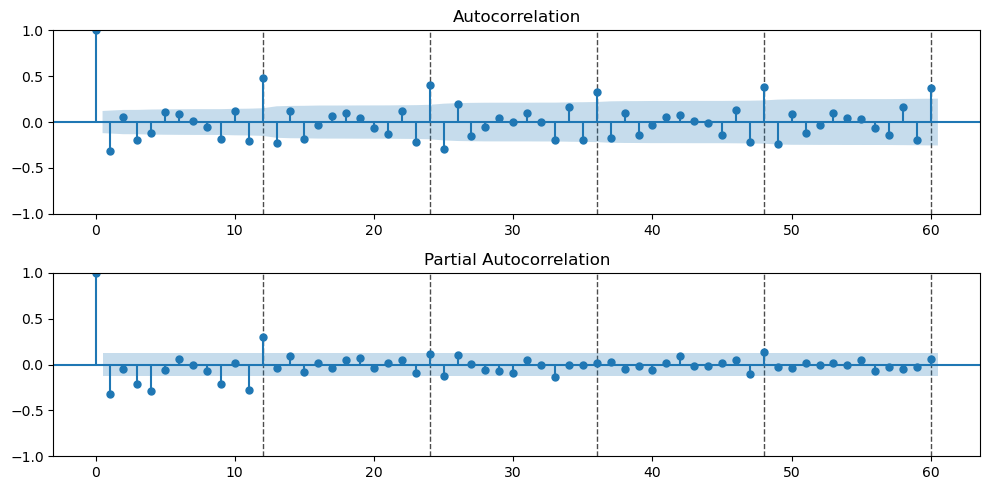

In [88]:
# Use the ACF and PACF plots of stationarized data to estimate initial orders
plot_acf_pacf(
    df_narcotics_diff, m=12, pacf_kws={'method': 'ywm'}, annotate_seas=True, nlags=60
);

**Splitting the Narcotics Data**

In [89]:
# Split the time series into training and test data (Remember we want to predict 6 months)
train, test = train_test_split(df_narcotics, test_size=6)

In [90]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -1676.922
Date:                Thu, 30 Nov 2023   AIC                           3369.844
Time:                        21:54:28   BIC                           3398.421
Sample:                    01-01-2001   HQIC                          3381.328
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3180      0.087      3.650      0.000       0.147       0.489
ar.L2          1.0269      0.075     13.689      0.000       0.880       1.174
ar.L3         -0.6808      0.051    -13.334      0.000      -0.781      -0.581
ar.L4         -0.4214      0.078     -5.391      0.000      -0.575      -0.268
ma.L1         -0.8127      0.061    -13.420      0.000      -0.931      -0.694
ma.L2         -0.7461      0.091     -8.227      0.000      -0.924      -0.568
ma.L3          0.9278      0.056     16.609      0.000       0.818       1.037
sigma2       2.15e+04   1909.224     11.262      0.000    1.78e+04    2.52e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.08   Jarque-Bera (JB):                 8.87
Prob(Q):                              0.30   Prob(JB):                         0.01
Heteroskedasticity (H):               0.40   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Forecasting**

In [92]:
# Make forecasts with your model.
forecast_df_narcotics = sarima.get_forecast(steps=len(test)).summary_frame()

In [93]:
forecast_df_narcotics['mean']

2023-01-01    1483.573367
2023-02-01    1474.214343
2023-03-01    1556.312399
2023-04-01    1669.153257
2023-05-01    1832.139883
2023-06-01    1947.904355
Freq: MS, Name: mean, dtype: float64

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Date'>)

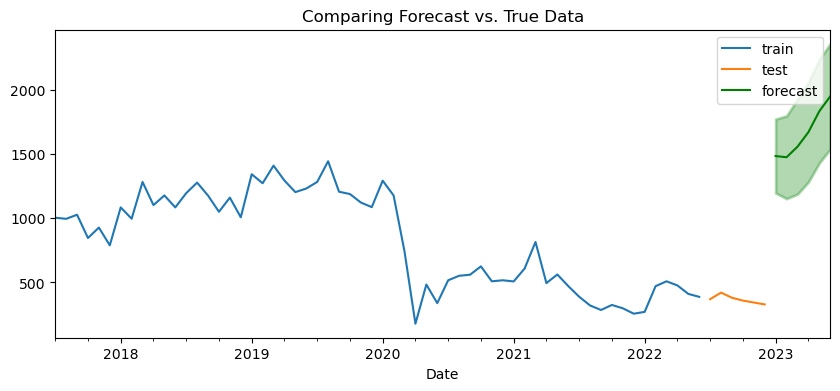

In [94]:
# Plot the forecasts versus the test data
plot_forecast(train, test, forecast_df_narcotics, n_train_lags=60)

In [95]:
# Obtain metrics for evaluation
regression_metrics_ts(test, forecast_df_narcotics['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,293.216
- MSE = 1,713,763.085
- RMSE = 1,309.108
- R^2 = -1,992.778
- MAPE = 358.20%


In [96]:
# Tune with pmdarima's auto_arima
auto_model = pm.auto_arima(train, seasonal=True)

In [97]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  258
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1808.410
Date:                Thu, 30 Nov 2023   AIC                           3624.821
Time:                        21:55:47   BIC                           3639.017
Sample:                    01-01-2001   HQIC                          3630.530
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -9.6423      3.793     -2.542      0.011     -17.077      -2.208
ar.L1          0.3881      0.082      4.712      0.000       0.227       0.549
ma.L1         -0.8062      0.057    -14.135      0.000      -0.918      -0.694
sigma2      7.583e+04   5378.574     14.098      0.000    6.53e+04    8.64e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                21.55
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [98]:
auto_model.order, auto_model.seasonal_order

((1, 1, 1), (0, 0, 0, 0))

In [99]:
# Fit a model on training data with the best parameters from auto_arima
training_model = tsa.ARIMA(train, order = auto_model.order).fit()

In [101]:
forecast_df2_narcotics = training_model.get_forecast(steps=len(test)).summary_frame()

In [102]:
# Obtain metrics for evaluation
regression_metrics_ts(test, forecast_df2_narcotics['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 42.411
- MSE = 2,241.732
- RMSE = 47.347
- R^2 = -1.608
- MAPE = 12.04%


(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Date'>)

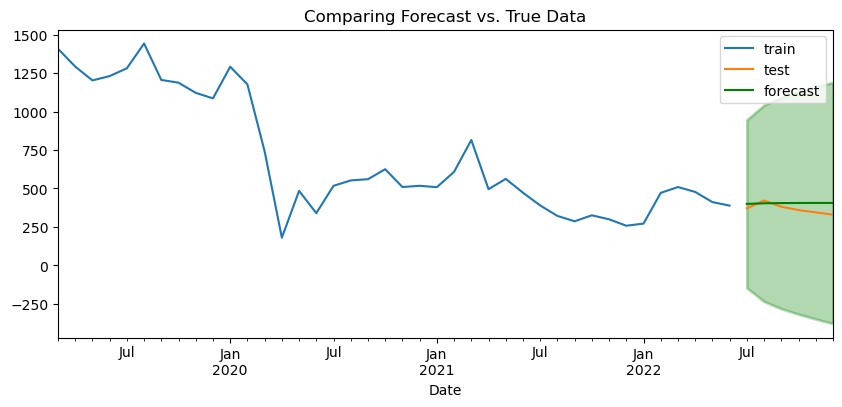

In [103]:
# Make forecasts with the auto_arima model
# Plot the forecasts versus the test data
plot_forecast(train, test, forecast_df2_narcotics, n_train_lags=40)

In [104]:
# using the the second forcast data 
p = 1
d = 1 # 2nd forcasted above
q = 1

P = 0
D = 0 # 2nd forcasted above
Q = 0

m = 0

sarima = tsa.ARIMA(df_narcotics, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()

In [105]:
final_forecast_narcotics = sarima.get_forecast(steps=6).summary_frame()

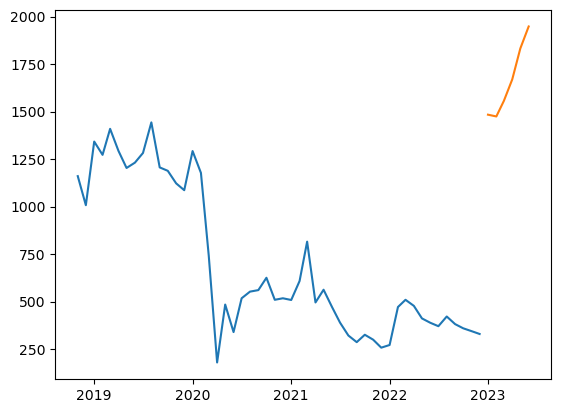

In [106]:
plt.plot(df_narcotics.tail(50))
plt.plot(final_forecast['mean'])

In [107]:
assault_ts.tail()

Date
2022-08-01    1984
2022-09-01    1894
2022-10-01    1840
2022-11-01    1659
2022-12-01    1570
Freq: MS, dtype: int64

In [109]:
final_forecast_narcotics

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-01-01,348.323456,275.895044,-192.420893,889.067805
2023-02-01,355.223343,322.433878,-276.735446,987.182131
2023-03-01,357.687107,346.889324,-322.203475,1037.577688
2023-04-01,358.566850,365.153515,-357.120888,1074.254589
2023-05-01,358.880983,381.096472,-388.054377,1105.816344
2023-06-01,358.993152,395.914700,-416.985401,1134.971704


In [110]:
final_forecast_narcotics['mean'][-1] - final_forecast_narcotics['mean'][0]
print(f"The predicted net change is {final_forecast_narcotics['mean'][-1] - final_forecast_narcotics['mean'][0]}. ")

The predicted net change is 10.669695753965925. 


In [111]:
(10.669695753965925 / final_forecast_narcotics['mean'][-1]) * 100
print(f"The raw delta percentage is {(10.669695753965925 / final_forecast['mean'][-1]) * 100}.")

The raw delta percentage is 0.5477525489024189.


### Final Evaluation

> Of the two crimes, Assults forecasted to have the highest monthly count of crimes at the end of the forecast.

>Of the two crimes, Assults forecasted to have the highest net change by the end of the forecast.

>Of the two crimes, Assults forecasted to have the highest percent change by the end of the forecast.

### Final Recommendations

>My recommendations would be to implicate new processes to reduce the Assult crimes, to better serve the safety for everyone.